In [1]:
from environment2 import Environment2
from keras import applications, optimizers
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint
from numpy.lib.arraypad import _validate_lengths
import matplotlib.pyplot as plt
from math import ceil
from PIL import Image
from ssim import compute_ssim
import os
import numpy as np

Using TensorFlow backend.


In [2]:
model = load_model("vgg16scratch-d2-l1-RMSProp-10-128-0.8642-0.37.h.h5")

/Users/alexhe/Desktop/ssim.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


0.6174379941155835


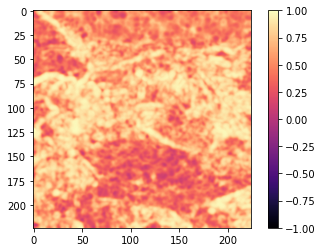

In [3]:
#test the computation of ssim for one pair of images

oimg = '00000020----benthos'
dimg = '00000020-noise-23-0.92295766-benthos'
ref_img = 'out2/' + oimg + '.jpg'
img = 'out2/' + dimg + '.jpg' 

image = Image.open(img).convert('L')
ref_image = Image.open(ref_img).convert('L')

if not image.size == ref_image.size :
    print('Image need to have the same size!')

image = np.array(image).astype(np.float64)
ref_image = np.array(ref_image).astype(np.float64)

mssim, ssim = compute_ssim(image, ref_image)
print(mssim)

plt.imshow(ssim, cmap='magma', vmin=-1, vmax=1)
plt.colorbar()
plt.show()


In [4]:
env = Environment2()

In [5]:
train_list, dev_list, test_list = env.generate_train_dev_test_lists(.95, .025, .025)

In [8]:
dict = {}
test_list.sort()
for img in range(len(test_list)):
    temp = test_list[img].split('-')
    dict[test_list[img]] = temp[0] + '----' + temp[-1]
    
ssim_scores = []
dir = 'out2/'
# some images are deleted because the image name has the seperator in it, causing string parsing failure
deleted = []
final_test_list = []
for i in range(len(test_list)):
    image = Image.open(dir + test_list[i]).convert('L')
    try: 
        ref = (dir + dict[test_list[i]])
        ref_image = Image.open(ref).convert('L')
    except FileNotFoundError:
        deleted.append(test_list[i])
        continue

    if not image.size == ref_image.size :
        print('Image need to have the same size!')
        
    image = np.array(image).astype(np.float64)
    ref_image = np.array(ref_image).astype(np.float64)

    mssim, ssim = compute_ssim(image, ref_image)
    ssim_scores.append(mssim)
    final_test_list.append(test_list[i])
print('Deleted ' + str(len(deleted)) + ' entries.')

Deleted 321 entries.


In [9]:
subsets= {i:[] for i in range(10)}

In [10]:
for i in range(len(final_test_list)):
    if ssim_scores[i] < .1: 
        subsets[0].append(final_test_list[i])
    elif ssim_scores[i] < .2: 
        subsets[1].append(final_test_list[i])
    elif ssim_scores[i] < .3: 
        subsets[2].append(final_test_list[i])
    elif ssim_scores[i] < .4: 
        subsets[3].append(final_test_list[i])
    elif ssim_scores[i] < .5: 
        subsets[4].append(final_test_list[i])
    elif ssim_scores[i] < .6: 
        subsets[5].append(final_test_list[i])
    elif ssim_scores[i] < .7: 
        subsets[6].append(final_test_list[i])
    elif ssim_scores[i] < .8: 
        subsets[7].append(final_test_list[i])
    elif ssim_scores[i] < .9: 
        subsets[8].append(final_test_list[i])
    elif ssim_scores[i] < 1: 
        subsets[9].append(final_test_list[i])
        

In [12]:
batch_size = 256
test_scores = []
test_acc = []
for i in range(10):
    sublist = subsets[i]
    if len(sublist) == 0:
        test_scores.append(0)
        test_acc.append(0)
        continue
        
    test_steps = ceil(len(sublist)/batch_size)
    score = model.evaluate_generator(env.single_distortion_data_generator(sublist, batch_size=batch_size, flatten=False, batch_name="test", steps=test_steps,label_scheme=1),
                                            steps=test_steps)
    test_scores.append(score[0])
    test_acc.append(score[1])
    print(str(i) + 'th tranche has ' + str(len(sublist)) + ' images - test score: ' + str(score[0]) + '  test acc: ' + str(score[1]))
    

1th tranche has 6 images - test score: 0.015132201835513115  test acc: 1.0
2th tranche has 36 images - test score: 0.01530701294541359  test acc: 1.0
3th tranche has 115 images - test score: 0.028824876993894577  test acc: 1.0
4th tranche has 272 images - test score: 0.032882921397686005  test acc: 1.0
5th tranche has 394 images - test score: 0.04758717119693756  test acc: 0.994140625
6th tranche has 596 images - test score: 0.05384966731071472  test acc: 0.99609375
7th tranche has 708 images - test score: 0.09386730939149857  test acc: 0.9908854365348816
8th tranche has 814 images - test score: 0.14535528421401978  test acc: 0.96484375
9th tranche has 1249 images - test score: 0.5977123975753784  test acc: 0.83203125
